In [1]:
from __future__ import division, print_function, absolute_import
import logging
import time
import tensorflow as tf
import os
tf.logging.set_verbosity(tf.logging.ERROR)
import numpy as np
from config import pathDict
from conv_net.train import Train
from conv_net.test import Test
from data_transformation.data_prep import get_intersecting_images_pin, dumpStratifiedBatches_balanced_class
from plot import Plot
import pandas as pd
import seaborn as sns
%matplotlib inline
sns.set_style("whitegrid")


which_net = 'resnet'
batch_prepare = True
train = True
test = True

INPUT the RUN NAME: Options : ("A new run name" or "Any Previous Run Name"
 WHICH_RUN = sam_new
INPUT: Image-type OPTIONS: (assessor, assessor_code, aerial, overlayed, aerial_cropped, streetside and ensemble 
 IMAGE_TYPE = aerial_cropped


In [5]:
# from clean_directories import clean
# clean(dict(overlayed='summary,batch'),which_vendor='google', which_model='resnet')

## PREPARE/DUMP BATCHES:

In [2]:
start_time = time.time()

max_batches = 2

if batch_prepare:
    start_time = time.time()
    
    cmn_land_pins, cmn_house_pins = get_intersecting_images_pin(is_assessor=False, is_aerial=True,
                                                                is_streetside=False, is_overlayed=True,
                                                                is_aerial_cropped=True, is_training=True)
    print(len(cmn_land_pins), len(cmn_house_pins))
    
    tr_batch_size = 128
    ts_batch_size = (len(cmn_land_pins) + len(cmn_house_pins)) // 10
    cv_batch_size = (len(cmn_land_pins) + len(cmn_house_pins)) // 10
    
    dumpStratifiedBatches_balanced_class(cmn_land_pins, cmn_house_pins, ts_batch_size=ts_batch_size,
                                         cv_batch_size=cv_batch_size, tr_batch_size=tr_batch_size,
                                         image_type='aerial_cropped', 
                                         img_in_shape=[400, 400, 3],
                                         img_out_shape=[224, 224, 3],
                                         img_crop_shape=[128, 128, 3], 
                                         img_resize_shape=[128, 128, 3],
                                         shuffle_seed=873, get_stats=True, max_batches=max_batches, is_training=True)

print ('--------------- %s seconds ------------------'%(time.time() - start_time))


5733 5733
--------------- 15.794015884399414 seconds ------------------


# EVALUATE MODELS:
------------

# TRAIN MODEL: Aerial Cropped
------------

## Train  learning_rate = 0.0001
-----------

In [2]:
max_batches = 70
start_time = time.time()
if train:
    tr_obj = Train(dict(pprocessor_inp_img_shape=[224,224,3],
                        pprocessor_inp_crop_shape=[],
                        model_inp_img_shape=[224,224,3],
                        learning_rate=0.0005,
                        use_checkpoint=True,
                        save_checkpoint=True,
                        write_tensorboard_summary=False
                        ),
              device_type='gpu',
              which_net='resnet')
    (tr_loss_arr, tr_acc_arr, tr_precision_arr, tr_recall_arr, 
     cv_loss_arr, cv_acc_arr, cv_precision_arr, cv_recall_arr,
     l_rate_arr)  = tr_obj.run(num_epochs=10, num_batches=max_batches, get_stats_at=10)# + 1)
    
print('----------%s seconds------------'%(str(time.time() - start_time)))

Dumping/Retreiving Checkpoints to %s C:\Users\newline\Documents\ImageClassification\data\checkpoints\sam_new\aerial_cropped\resnet
Learning Rate: Initial:  0.0005
Checkpoints not found, Hence starting at batch 0 and epoch 0........
----------1917.5756480693817 seconds------------


In [3]:
print ('Mean Values: train_loss = %s, train_acc = %s, train_precision = %s, train_recall = %s, cv_loss = %s, cv_acc = %s, cv_precision = %s, cv_recall = %s'%(
    np.mean(tr_loss_arr), np.mean(tr_acc_arr), np.mean(tr_precision_arr), np.mean(tr_recall_arr), np.mean(cv_loss_arr), np.mean(cv_acc_arr), np.mean(cv_precision_arr), np.mean(cv_recall_arr)))

Mean Values: train_loss = 1.51379, train_acc = 0.910507, train_precision = 0.916862192518, train_recall = 0.909442934783, cv_loss = 2.02523, cv_acc = 0.86006, cv_precision = 0.876594982126, cv_recall = 0.843305908751


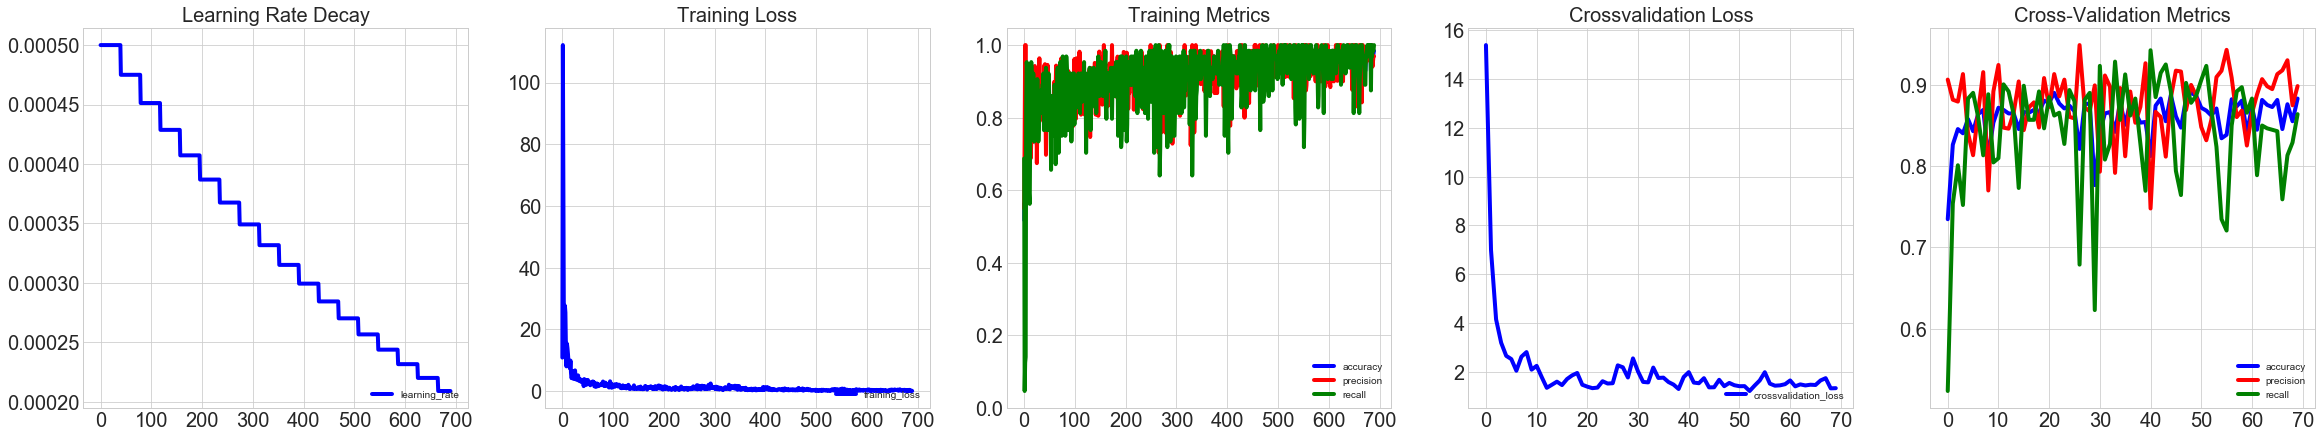

In [4]:
oj = Plot(rows=1, columns=5, fig_size=(40,7))

l_rate_df = pd.DataFrame(l_rate_arr, columns=['learning_rate'])
oj.vizualize(data=l_rate_df, colX=None, colY=None, label_col=None, viz_type='line', params={'title':'Learning Rate Decay'})

tr_loss_df = pd.DataFrame(tr_loss_arr, columns=['training_loss'])
oj.vizualize(data=tr_loss_df, colX=None, colY=None, label_col=None, viz_type='line', params={'title':'Training Loss'})
tr_data = pd.DataFrame(np.column_stack((tr_acc_arr, tr_precision_arr, tr_recall_arr)), columns=['accuracy', 'precision', 'recall'])
oj.vizualize(data=tr_data, colX=None, colY=None, label_col=None, viz_type='line', params={'title':'Training Metrics'})

cv_loss_df = pd.DataFrame(cv_loss_arr, columns=['crossvalidation_loss'])
oj.vizualize(data=cv_loss_df, colX=None, colY=None, label_col=None, viz_type='line', params={'title':'Crossvalidation Loss'})
cv_data = pd.DataFrame(np.column_stack((cv_acc_arr, cv_precision_arr, cv_recall_arr)), columns=['accuracy', 'precision', 'recall'])
oj.vizualize(data=cv_data, colX=None, colY=None, label_col=None, viz_type='line', params={'title':'Cross-Validation Metrics'})

### Cross Validation and Test : learning_rate = 0.0001

In [5]:
which_data = 'cvalid'
if test:
    tsoj = Test(params=dict(inp_img_shape=[400,400,3],
                     crop_shape=[96, 96, 3],
                     out_img_shape=[224, 224, 3]),
         which_net=which_net,
         image_type=image_type)
    cv_loss_arr, cv_acc_arr, cv_precision_arr, cv_recall_arr = tsoj.run(which_data=which_data, dump_stats=True)

Dumping Checkpoints to %s /Users/sam/All-Program/App-DataSet/HouseClassification/data_models/aerial_images/google/checkpoint/resnet
Dumping Tensorboard Summary to %s /Users/sam/All-Program/App-DataSet/HouseClassification/data_models/aerial_images/google/summary/resnet
Test Graphs: RESNET
Learning Rate: Initial:  0.0001
Test Graphs: RESNET
Learning Rate: Initial:  0.0001
Test Graphs: RESNET
Learning Rate: Initial:  0.0001
Test Graphs: RESNET
Learning Rate: Initial:  0.0001
Test Graphs: RESNET
Learning Rate: Initial:  0.0001
Test Graphs: RESNET
Learning Rate: Initial:  0.0001
Test Graphs: RESNET
Learning Rate: Initial:  0.0001
Test Graphs: RESNET
Learning Rate: Initial:  0.0001
Test Graphs: RESNET
Learning Rate: Initial:  0.0001
Test Graphs: RESNET
Learning Rate: Initial:  0.0001


In [7]:
which_data = 'test'
if test:
    tsoj = Test(params=dict(inp_img_shape=[400,400,3],
                     crop_shape=[96, 96, 3],
                     out_img_shape=[224, 224, 3]),
         which_net=which_net,
         image_type=image_type)
    ts_loss_arr, ts_acc_arr, ts_precision_arr, ts_recall_arr = tsoj.run(which_data=which_data, dump_stats=True)

Dumping Checkpoints to %s /Users/sam/All-Program/App-DataSet/HouseClassification/data_models/aerial_images/google/checkpoint/resnet
Dumping Tensorboard Summary to %s /Users/sam/All-Program/App-DataSet/HouseClassification/data_models/aerial_images/google/summary/resnet
Test Graphs: RESNET
Learning Rate: Initial:  0.0001
Test Graphs: RESNET
Learning Rate: Initial:  0.0001
Test Graphs: RESNET
Learning Rate: Initial:  0.0001
Test Graphs: RESNET
Learning Rate: Initial:  0.0001
Test Graphs: RESNET
Learning Rate: Initial:  0.0001
Test Graphs: RESNET
Learning Rate: Initial:  0.0001
Test Graphs: RESNET
Learning Rate: Initial:  0.0001
Test Graphs: RESNET
Learning Rate: Initial:  0.0001
Test Graphs: RESNET
Learning Rate: Initial:  0.0001
Test Graphs: RESNET
Learning Rate: Initial:  0.0001


In [8]:
print ('Mean Values: cvalid_loss = %s, cvalid_acc = %s, cvalid_precision = %s, cvalid_recall = %s, test_loss = %s, test_acc = %s, test_precision = %s, test_recall = %s'%(
    np.mean(cv_loss_arr), np.mean(cv_acc_arr), np.mean(cv_precision_arr), np.mean(cv_recall_arr), np.mean(ts_loss_arr), np.mean(ts_acc_arr), np.mean(ts_precision_arr), np.mean(ts_recall_arr)))

Mean Values: cvalid_loss = 3.31833, cvalid_acc = 0.792634, cvalid_precision = 0.800443959014, cvalid_recall = 0.78802946593, test_loss = 3.18185, test_acc = 0.787201, test_precision = 0.785910674674, test_recall = 0.797974217311


In [2]:
which_data = 'cvalid'
tsoj = Test(params=dict(pprocessor_inp_img_shape=[224,224,3],
                        pprocessor_inp_crop_shape=[],
                        model_inp_img_shape=[224, 224, 3]),
                    device_type = 'gpu',
                    which_net='resnet')
fnl_tst_metric_stack = tsoj.run(use_checkpoint_for_run='sam_new',
                                use_checkpoint_for_imageType='aerial_cropped',
                                optional_batch_name=None,
                                which_checkpoint='all',
                                dump_stats=True)

print (fnl_tst_metric_stack)

Test Graphs: RESNET
Learning Rate: Initial:  0.005
Batch path /Users/sam/All-Program/App-DataSet/HouseClassification/batch_data/sam_new/aerial_cropped, batch_names: ['test', 'cvalid']
Test Graphs: RESNET
Learning Rate: Initial:  0.005
Batch path /Users/sam/All-Program/App-DataSet/HouseClassification/batch_data/sam_new/aerial_cropped, batch_names: ['test', 'cvalid']
Test Graphs: RESNET
Learning Rate: Initial:  0.005
Batch path /Users/sam/All-Program/App-DataSet/HouseClassification/batch_data/sam_new/aerial_cropped, batch_names: ['test', 'cvalid']
Test Graphs: RESNET
Learning Rate: Initial:  0.005
Batch path /Users/sam/All-Program/App-DataSet/HouseClassification/batch_data/sam_new/aerial_cropped, batch_names: ['test', 'cvalid']
Test Graphs: RESNET
Learning Rate: Initial:  0.005
Batch path /Users/sam/All-Program/App-DataSet/HouseClassification/batch_data/sam_new/aerial_cropped, batch_names: ['test', 'cvalid']
Test Graphs: RESNET
Learning Rate: Initial:  0.005
Batch path /Users/sam/All-Pro

In [3]:
prediction_outcomes_path = os.path.join(pathDict['statistics_path'], 'prediction_stats', 'pred_outcomes.csv')
prediction_metrics_path = os.path.join(pathDict['statistics_path'], 'prediction_stats', 'pred_metrics.csv')
prediction_outcomes = pd.read_csv(prediction_outcomes_path)
prediction_metrics = pd.read_csv(prediction_metrics_path)

In [4]:
prediction_outcomes.head()

,checkpoint,test_batch,true_label,pred_label,pred_prob
0,epoch_0_batch_9,test,0.0,0,1.000
1,epoch_0_batch_9,test,0.0,0,0.994
2,epoch_0_batch_9,test,0.0,0,1.000
3,epoch_0_batch_9,test,0.0,0,1.000
4,epoch_0_batch_9,test,0.0,0,1.000


In [6]:
prediction_metrics

,checkpoint,test_batch,test_loss,test_acc,test_precsion,test_recall
0,epoch_0_batch_9,test,9.593,0.810,0.810,0.810
1,epoch_0_batch_9,cvalid,11.268,0.791,0.783,0.805
2,epoch_0_batch_19,test,10.048,0.716,0.908,0.480
3,epoch_0_batch_19,cvalid,11.342,0.709,0.877,0.487
4,epoch_0_batch_29,test,3.697,0.847,0.842,0.855
5,epoch_0_batch_29,cvalid,4.391,0.825,0.824,0.827
6,epoch_0_batch_39,test,2.686,0.812,0.803,0.827
7,epoch_0_batch_39,cvalid,2.933,0.803,0.803,0.803
8,epoch_0_batch_49,test,2.165,0.871,0.884,0.853
9,epoch_0_batch_49,cvalid,2.787,0.847,0.859,0.831


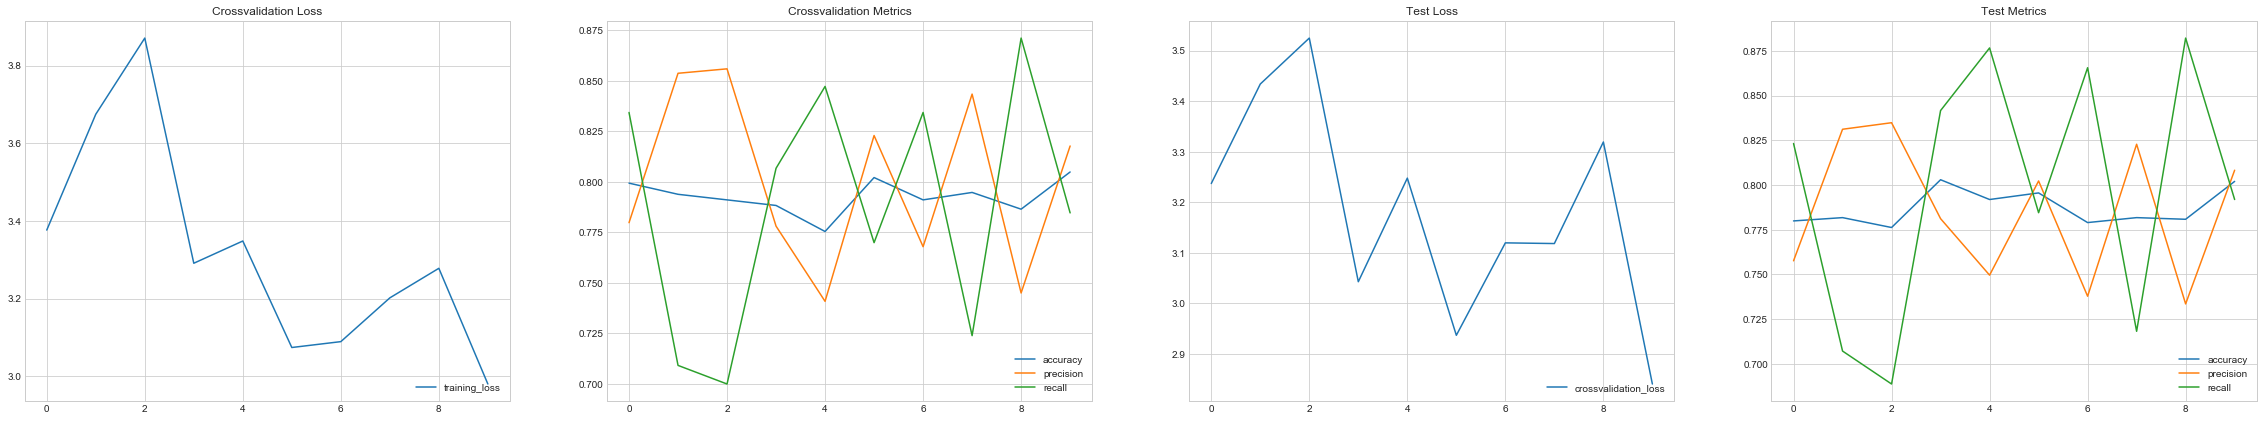

In [9]:
oj = Plot(rows=1, columns=4, fig_size=(40,7))
cv_loss_df = pd.DataFrame(cv_loss_arr, columns=['training_loss'])
oj.vizualize(data=cv_loss_df, colX=None, colY=None, label_col=None, viz_type='line', params={'title':'Crossvalidation Loss'})
cv_data = pd.DataFrame(np.column_stack((cv_acc_arr, cv_precision_arr, cv_recall_arr)), columns=['accuracy', 'precision', 'recall'])
oj.vizualize(data=cv_data, colX=None, colY=None, label_col=None, viz_type='line', params={'title':'Crossvalidation Metrics'})

ts_loss_df = pd.DataFrame(ts_loss_arr, columns=['crossvalidation_loss'])
oj.vizualize(data=ts_loss_df, colX=None, colY=None, label_col=None, viz_type='line', params={'title':'Test Loss'})
ts_data = pd.DataFrame(np.column_stack((ts_acc_arr, ts_precision_arr, ts_recall_arr)), columns=['accuracy', 'precision', 'recall'])
oj.vizualize(data=ts_data, colX=None, colY=None, label_col=None, viz_type='line', params={'title':'Test Metrics'})

In [3]:
max_batches = 1
start_time = time.time()
if train:
    tr_obj = Train(dict(pprocessor_inp_img_shape=[224,224,3],
                        pprocessor_inp_crop_shape=[],
                        model_inp_img_shape=[224,224,3],
                        learning_rate=0.0005,
                        use_checkpoint=True,
                        save_checkpoint=True,
                        write_tensorboard_summary=False
                        ),
              device_type='gpu',
              which_net='resnet')
    (tr_loss_arr, tr_acc_arr, tr_precision_arr, tr_recall_arr, 
     cv_loss_arr, cv_acc_arr, cv_precision_arr, cv_recall_arr,
     l_rate_arr)  = tr_obj.run(num_epochs=2, num_batches=max_batches, cv_num_batches=1, get_stats_at=1)# + 1)
    
print('----------%s seconds------------'%(str(time.time() - start_time)))

Dumping/Retreiving Checkpoints to %s /Users/sam/All-Program/App-DataSet/HouseClassification/checkpoints/sam_new/aerial_cropped/resnet
Learning Rate: Initial:  0.0005
Checkpoint latest at:  /Users/sam/All-Program/App-DataSet/HouseClassification/checkpoints/sam_new/aerial_cropped/resnet/resnet_epoch_0_batch_1
----------1284.6287338733673 seconds------------


In [2]:
which_data = 'cvalid'
tsoj = Test(params=dict(pprocessor_inp_img_shape=[224,224,3],
                        pprocessor_inp_crop_shape=[],
                        model_inp_img_shape=[224, 224, 3]),
                    device_type = 'gpu',
                    which_net='resnet')
fnl_tst_metric_stack = tsoj.run(use_checkpoint_for_run='sam_new',
                                use_checkpoint_for_imageType='aerial_cropped',
                                optional_batch_name=which_data,
                                which_checkpoint='max',
                                dump_stats=True)

print (fnl_tst_metric_stack)

Checkpoint latest at:  /Users/sam/All-Program/App-DataSet/HouseClassification/checkpoints/sam_new/aerial_cropped/resnet/resnet_epoch_4_batch_1
Test Graphs: RESNET
Learning Rate: Initial:  0.005
Batch path /Users/sam/All-Program/App-DataSet/HouseClassification/batch_data/sam_new/aerial_cropped, batch_names: ['cvalid']
[['epoch_4_batch_1' 'cvalid' 15.707 0.70999998 0.85299999999999998
  0.50800000000000001]]
